In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Mon Jan 26 15:48:04 PST 2026
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# V&V List from Docs

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

### Note: This notebook currently only shows results for the baseline scenario.

# Load Data

Results: 

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.0/model_spec/2026_01_22_17_36_03

Artifact:

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [11]:
locations = [
            'united_states_of_america',
            #  'brazil',
             'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    # 'results/abie_consistent_model_test/china/2026_01_11_13_36_17/results/',
    'results/model11.0/model_spec/2026_01_22_17_36_03/results/',
]

artifact_subdirs = ['artifacts/model8.3/' + x + '.hdf' for x in locations]
artifact_dirs = ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_subdir
                 for artifact_subdir in artifact_subdirs]
# artifact_dirs = ['/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf']
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf']

In [12]:
apath = artifact_dirs[0]
!ls $apath

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf


In [13]:
# .parquet files are now in subfolders...
[x for x in os.listdir(results_dirs[0]) ]#if 'parquet' in x]

['person_time_ever_eligible_for_bbbm_testing',
 'transition_count_alzheimers_disease_and_other_dementias',
 'counts_bbbm_tests',
 'counts_new_simulants',
 'counts_newly_eligible_for_bbbm_testing',
 'treatment_duration',
 'counts_baseline_tests_among_eligible',
 'person_time_alzheimers_disease_and_other_dementias',
 'ylls',
 'ylds',
 'deaths',
 'transition_count_treatment',
 'person_time_eligible_for_bbbm_testing',
 'person_time_treatment']

In [14]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [15]:
# filters = [('artifact_path', '==', artifact_dirs[0])]
filters=None
test = pd.read_parquet(results_dirs[0] + 'deaths', filters=filters)
# test['location'] = locations[0]
test#.artifact_path.unique()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,2284,0.0
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,2284,0.0
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2023,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,2284,0.0
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2023,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,2284,0.0
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2024,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,2284,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2369995,deaths,cause,other_causes,other_causes,95_plus,2098,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,63,6810,59.0
2369996,deaths,cause,other_causes,other_causes,95_plus,2099,Female,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,63,6810,598.0
2369997,deaths,cause,other_causes,other_causes,95_plus,2099,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,63,6810,68.0
2369998,deaths,cause,other_causes,other_causes,95_plus,2100,Female,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,63,6810,642.0


In [16]:
test.random_seed.nunique()

5

In [17]:
test.input_draw.nunique()

25

In [18]:
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf',
       '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'],
      dtype=object)

In [19]:
[[('artifact_path', '==', artifact_dir)]
                 for artifact_dir in artifact_dirs
                 ]

[[('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf')],
 [('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf')]]

In [20]:
# # Model 10.0 was run with 100 seeds instead of 5, so let's just filter
# # everything to 5 seeds to make it all run faster
# # seeds = [338, 6520, 3585, 7745, 539]
# seeds = [7179, 2599, 1534, 386, 1935]
# seed_filter = ('random_seed', 'in', seeds)

def print_memory_usage(df, label=''):
    """Print the memory usage of a dataframe in megabytes."""
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB', label)

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

def load_df(measure):
    # data = pd.DataFrame()
    dfs_by_location = []
    data_all = pd.read_parquet(
        # NOTE: .parquet files are in subfolders after Vivarium update
        results_dirs[0] + measure, #+ '.parquet',
        # # Filter random seeds
        # filters = [seed_filter],
        # # Combine location filters with OR using disjunctive normal form
        # filters=[[('artifact_path', '==', artifact_dir)]
        #          for artifact_dir in artifact_dirs
        #          ],
    )
    print_memory_usage(data_all, 'for parquet file loaded into memory')
    convert_to_categorical(data_all, inplace=True)
    print_memory_usage(data_all, 'after converting to categorical')
    # Loop through unique locations (artifact paths), and aggregate
    # random seeds for each one, then concatenate
    for location, artifact in zip(locations, artifact_dirs):
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols, observed=True)['value'].sum().reset_index()
        
        temp['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        # data = pd.concat([data, temp], ignore_index=True)
        dfs_by_location.append(temp)
    data = pd.concat(dfs_by_location, ignore_index=True)
    print_memory_usage(data, 'after aggregating seeds')
    convert_to_categorical(data, exclude_cols=['event_year'], inplace=True)
    print_memory_usage(data, 'after converting aggregated data to categoricals')
    return data

In [21]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
# person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

10377.054836 MB for parquet file loaded into memory
426.612034 MB after converting to categorical
415.939899 MB after aggregating seeds
115.18715 MB after converting aggregated data to categoricals


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.000000,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.000000,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.000000,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.000000,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.000000,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,60.791239,china
4265996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,39.364819,china
4265997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,39.364819,china
4265998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,45.842574,china


In [22]:
person_time.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect', 'waning_effect', 'no_effect_after_treatment', 'no_effect_never_treated']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [23]:
person_time.query("location=='china'").artifact_path.nunique()

1

In [24]:
person_time.location.unique()

['united_states_of_america', 'china']
Categories (2, object): ['china', 'united_states_of_america']

In [25]:
person_time.memory_usage(deep=True)

Index                 132
measure           4266176
entity_type       4266170
entity            4266203
sub_entity        4266383
age_group         4267530
event_year       34128000
sex               4266232
treatment         4266636
artifact_path     4266425
scenario          4266256
input_draw        4266756
value            34128000
location          4266251
dtype: int64

In [26]:
person_time.dtypes

measure          category
entity_type      category
entity           category
sub_entity       category
age_group        category
event_year          int64
sex              category
treatment        category
artifact_path    category
scenario         category
input_draw       category
value             float64
location         category
dtype: object

In [27]:
# This is insane -- 45 GB!
print_memory_usage(person_time)

115.18715 MB 


In [28]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [29]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        9.629146e+08
alzheimers_disease_state                      5.749158e+08
alzheimers_mild_cognitive_impairment_state    4.177614e+08
Name: value, dtype: float64

In [30]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
china                    2022       25_to_29                             0.000000e+00   
                                    30_to_34                             9.965777e-01   
                                    35_to_39                             1.993155e+00   
                                    40_to_44                             1.463973e+03   
                                    45_to_49                             2.608741e+04   
...                                                                               ...   
united_states_of_america 2100       75_to_79                             1.078586e+06   
                                    80_to_84                             1.345467e+06   
                                    85_to_89                             1.023352e+06   
                                    90_to_94                             4.590934e+05   
                                    95_plus                              1.157963e+05   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
china                    2022       25_to_29                   0.000000   
                                    30_to_34                   0.000000   
                                    35_to_39                   0.000000   
                                    40_to_44                   0.996578   
                                    45_to_49                4344.082136   
...                                                                 ...   
united_states_of_america 2100       75_to_79              459668.966461   
                                    80_to_84              699866.113621   
                                    85_to_89              771001.330595   
                                    90_to_94              500209.248460   
                                    95_plus               184902.532512   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
china                    2022       25_to_29                                     0.000000  
                                    30_to_34                                     0.000000  
                                    35_to_39                                     0.000000  
                                    40_to_44                                     1.993155  
                                    45_to_49                                  8307.471595  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                364694.614648  
                                    80_to_84                                542984.854209  
                                    85_to_89                                544169.785079  
                                    90_to_94                                308518.527036  
                                    95_plus                                 103624.646133  

[2370 rows x 3 columns]

In [31]:
#assert np.all(person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [32]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

6989.139829 MB for parquet file loaded into memory
284.412032 MB after converting to categorical
277.294897 MB after aggregating seeds
76.793148 MB after converting aggregated data to categoricals


0.0

In [33]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [34]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [35]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [36]:
out_counts

alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
china                    2022       25_to_29                                      0.0   
                                    30_to_34                                      0.0   
                                    35_to_39                                      0.0   
                                    40_to_44                                    114.0   
                                    45_to_49                                   3918.0   
...                                                                               ...   
united_states_of_america 2100       75_to_79                                 144381.0   
                                    80_to_84                                 188942.0   
                                    85_to_89                                 153656.0   
                                    90_to_94                                  69995.0   
                                    95_plus                                   17479.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
china                    2022       25_to_29                                          0.0  
                                    30_to_34                                          0.0  
                                    35_to_39                                          0.0  
                                    40_to_44                                          2.0  
                                    45_to_49                                       2162.0  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                      93739.0  
                                    80_to_84                                     137317.0  
                                    85_to_89                                     135809.0  
                                    90_to_94                                      72889.0  
                                    95_plus                                       23101.0  

[2370 rows x 2 columns]

In [37]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

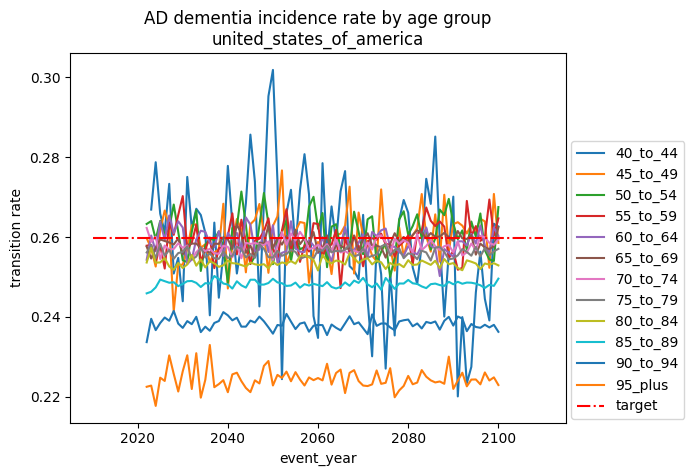

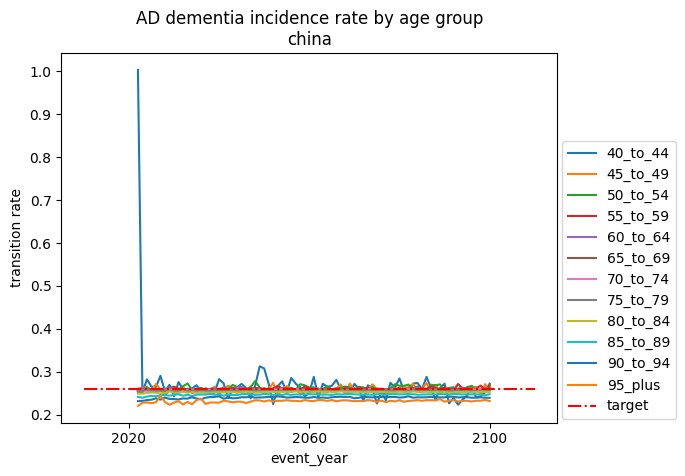

In [38]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    # .iloc[:,3:] filters out the first 3 age groups, which have 0 or
    # very few people
    t.loc[location].iloc[:,3:].plot(ylabel='transition rate')
    plt.title(f"AD dementia incidence rate by age group\n{location}")
    plt.hlines(1/3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [39]:
1 / 3.85

0.2597402597402597

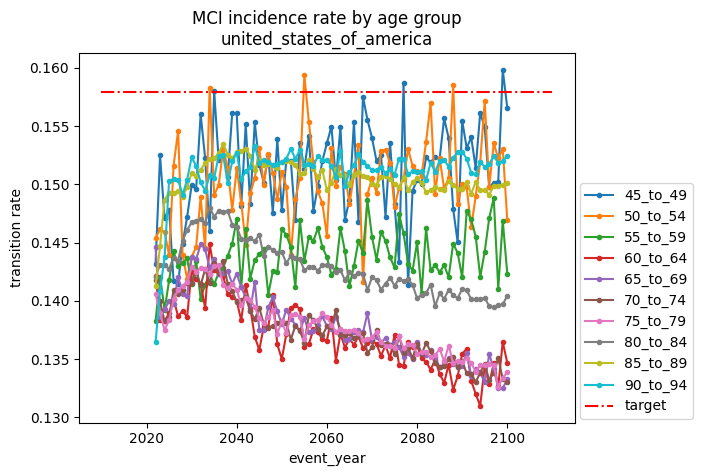

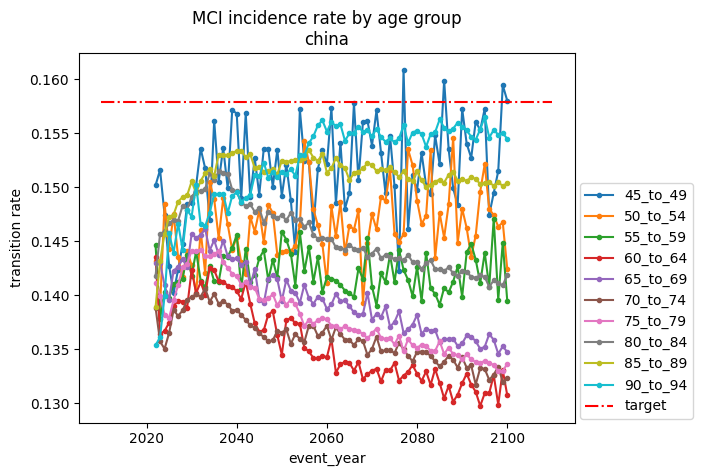

In [40]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.', ylabel='transition rate')
    plt.title(location)
    plt.title(f"MCI incidence rate by age group\n{location}")
    # target is 1 / mean of Weibull distribution
    plt.hlines(0.15791673988674756, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [41]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

# Load counts of new simulants

In [42]:
new_sims = load_df('counts_new_simulants')
new_sims.head()

307.516317 MB for parquet file loaded into memory
17.785466 MB after converting to categorical
21.925831 MB after aggregating seeds
5.217582 MB after converting aggregated data to categoricals


,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location
0,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america
1,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america
2,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america
3,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america
4,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america


In [43]:
new_sims_by_year_and_age = new_sims.groupby(['location', 'event_year', 'age_group', ]).value.sum()

bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims_by_year_and_age
)
#bbbm_duration_est

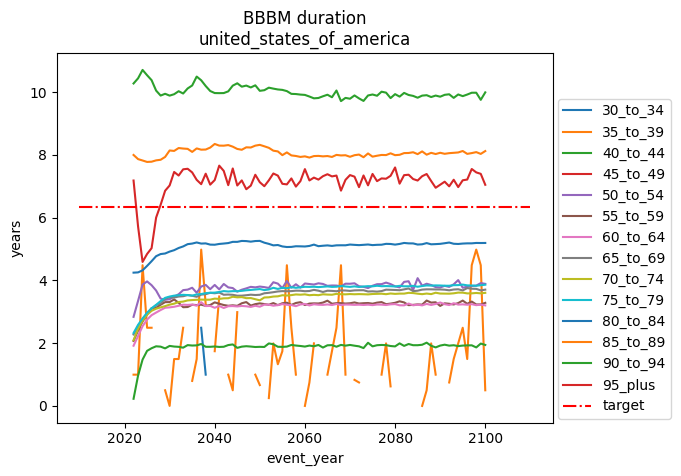

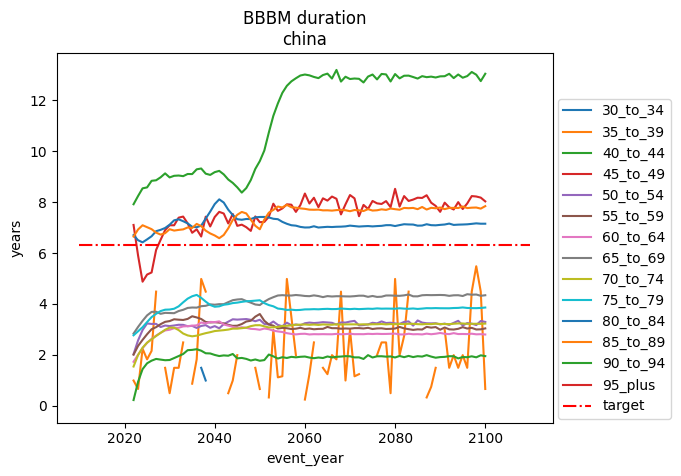

In [44]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    # Target is mean of Weibull distribution
    plt.hlines(6.332450889735727, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'BBBM duration\n{location}')
    plt.legend(loc=(1.01, .01))

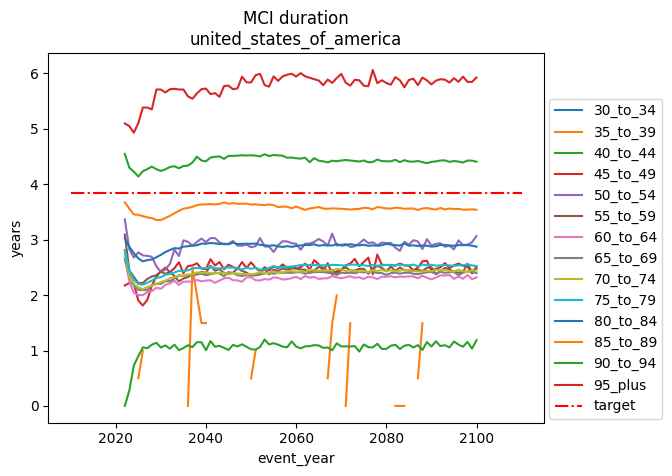

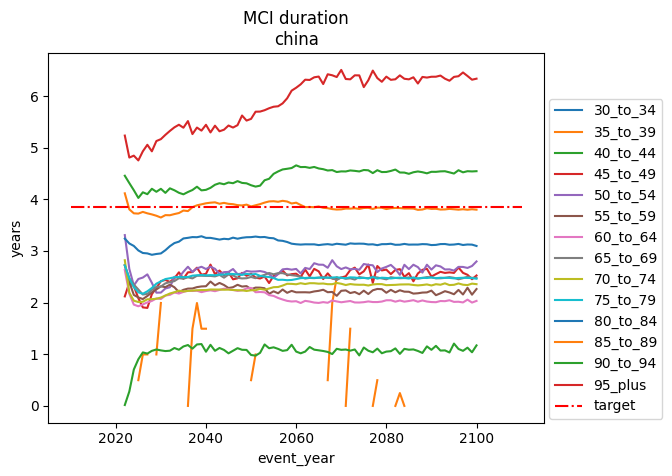

In [45]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    plt.hlines(3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'MCI duration\n{location}')
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [46]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

# Load deaths dataframe
deaths = load_df('deaths')

def calculate_ocmr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time.groupby(cols).sum(numeric_only=True)

    # deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr(person_time, deaths)

771.444503 MB for parquet file loaded into memory
45.041323 MB after converting to categorical
45.745188 MB after aggregating seeds
12.328439 MB after converting aggregated data to categoricals
CPU times: user 17.8 s, sys: 405 ms, total: 18.2 s
Wall time: 17.4 s


In [47]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [48]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [49]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


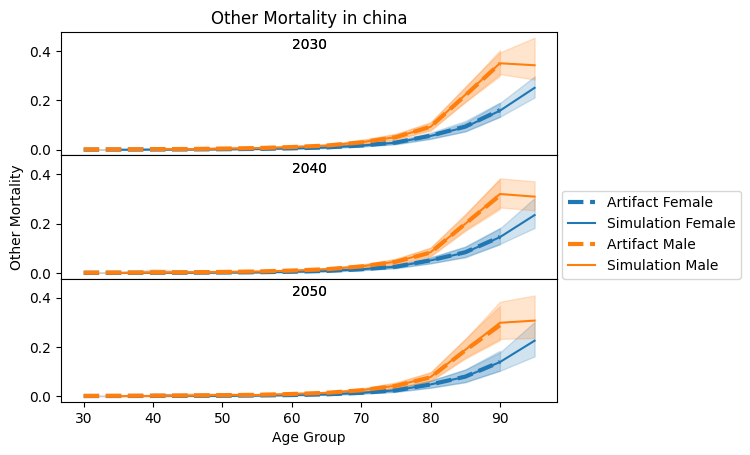

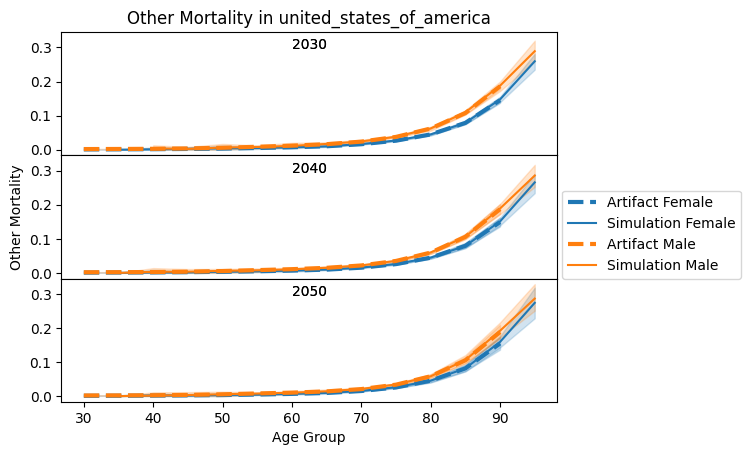

In [50]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [51]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

In [52]:
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.000000,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.000000,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.000000,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.000000,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.000000,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,60.791239,china
4265996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,39.364819,china
4265997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,39.364819,china
4265998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,45.842574,china


In [53]:
deaths

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...
473995,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,468.0,china
473996,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,438.0,china
473997,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,315.0,china
473998,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,253.0,china


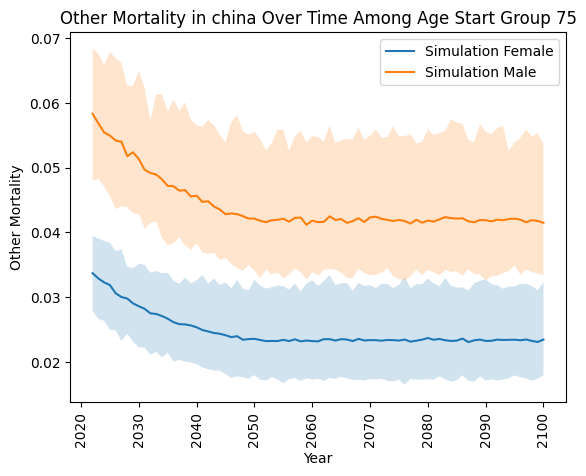

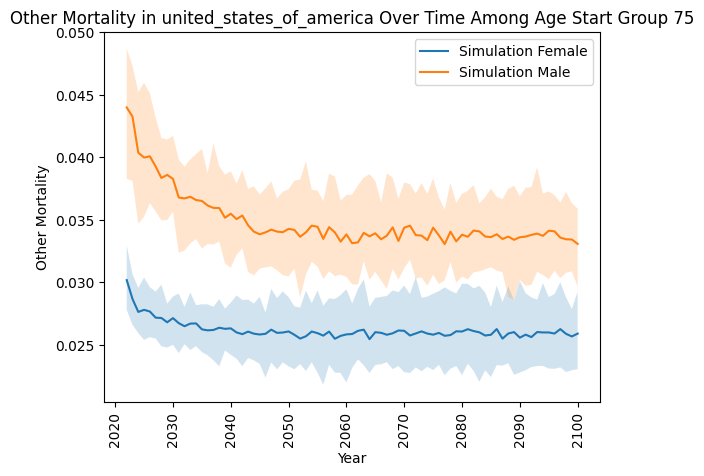

<Figure size 640x480 with 0 Axes>

In [54]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s dementia EMR against GBD

In [55]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
scenario = 'baseline'
# severity = 'severe'

def calculate_emr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time.loc[
        (person_time.sub_entity == f'alzheimers_disease_state')
        & (person_time.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(infected) > 0

    # deaths0 = load_df('deaths')
    deaths = deaths.loc[
        (deaths.sub_entity == f'alzheimers_disease_state')
        & (deaths.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr(person_time, deaths)

In [56]:
sim_emr

,event_year,location,age_group,sex,scenario,age_start,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,china,30_to_34,Female,baseline,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,china,30_to_34,Male,baseline,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,china,35_to_39,Female,baseline,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,china,35_to_39,Male,baseline,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,china,40_to_44,Female,baseline,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,2100,united_states_of_america,85_to_89,Male,baseline,85.0,25.0,0.108843,0.015221,0.082999,0.086608,0.104395,0.135132,0.136554
4420,2100,united_states_of_america,90_to_94,Female,baseline,90.0,25.0,0.142454,0.016971,0.115269,0.116254,0.138080,0.174471,0.177386
4421,2100,united_states_of_america,90_to_94,Male,baseline,90.0,25.0,0.137267,0.019013,0.102146,0.102194,0.136568,0.173221,0.181199
4422,2100,united_states_of_america,95_plus,Female,baseline,95.0,25.0,0.177190,0.024500,0.138526,0.141479,0.177513,0.224680,0.232890


In [57]:
def load_artifact_cause_data(measure, year_start=2025):
    # out = pd.DataFrame()
    artifact_data = []
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = [f'year_start=={year_start}'])
        data = art.load(f'cause.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        # out = pd.concat([out, data])
        artifact_data.append(data)
    out = pd.concat(artifact_data)
    return out

In [58]:
print(art)

Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [59]:
art_emr = load_artifact_cause_data(f'alzheimers_consistent.excess_mortality_rate')
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Male,30,35,2025,2026,7.936454e-09,2.238392e-10,2.352777e-08,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate,united_states_of_america
1,Female,30,35,2025,2026,8.095870e-09,4.123460e-10,2.228134e-08,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate,united_states_of_america
2,Male,35,40,2025,2026,7.503084e-09,2.474884e-10,2.138320e-08,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate,united_states_of_america
3,Female,35,40,2025,2026,8.138804e-09,1.584946e-10,2.261747e-08,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate,united_states_of_america
4,Male,40,45,2025,2026,4.672178e-03,3.371834e-03,5.948665e-03,13,40 to 44,40_to_44,alzheimers_consistent.excess_mortality_rate,united_states_of_america


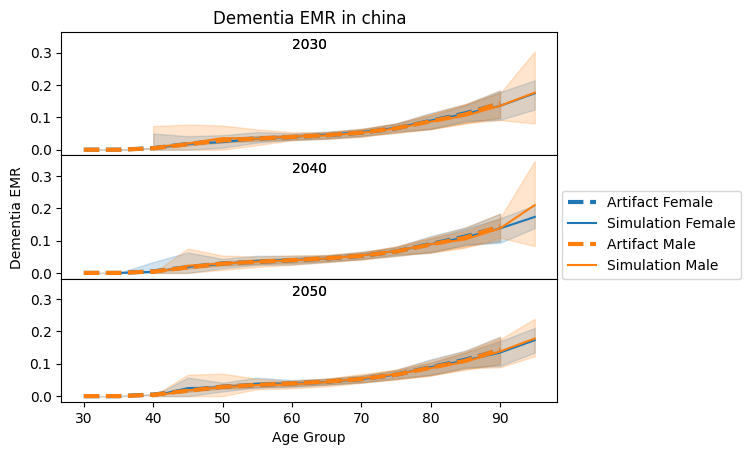

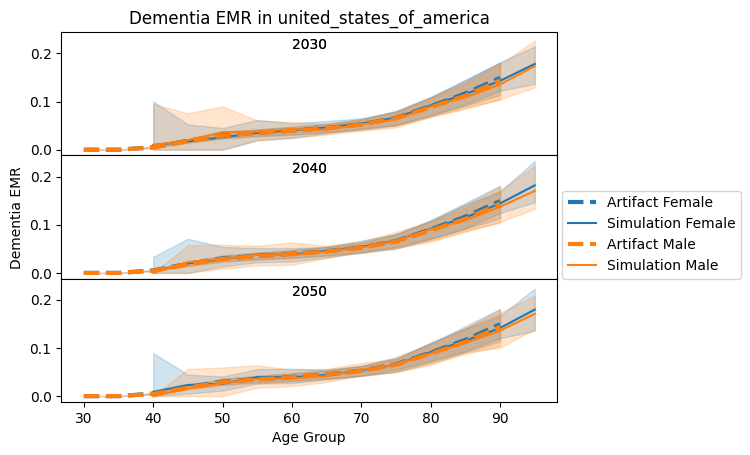

In [60]:
age_group_plot(f'Dementia EMR', sim_emr, art_emr, art_year=2025)

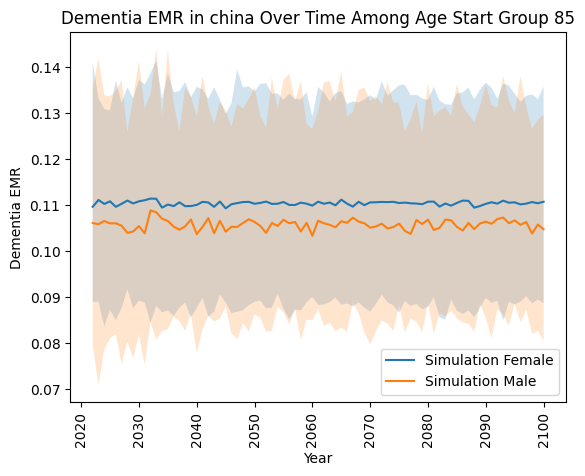

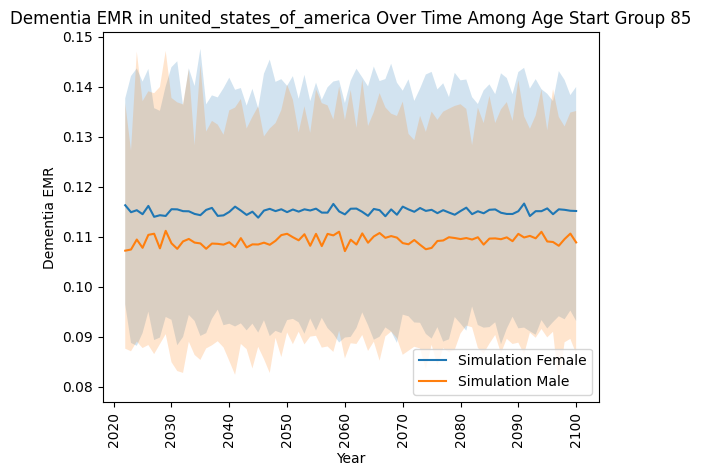

<Figure size 640x480 with 0 Axes>

In [61]:
over_time_plot(f'Dementia EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [62]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            # TODO: Which of these keys should I use?
            # # Output of MCMC, incidence of BBBM used in simulation:
            # 'cause.alzheimers_consistent.population_incidence_dementia'
            # # Used as input (target for calibration):
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0       draw_1  \
sex  age_start age_end location year_start year_end                             
Male 95.0      125.0   China    2046       2047      6138.805816  6713.248196   
                                2047       2048      6658.733530  7325.392687   
                                2048       2049      7284.805378  8062.256531   
                                2049       2050      7862.580906  8772.156109   
                                2050       2051      8283.709320  9342.524430   

                                                           draw_2  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047       8954.234085   
                                2047       2048       9850.786150   
                                2048       2049      10940.205757   
                                2049       2050      11997.157871   
                                2050       2051      12843.991622   

                                                           draw_3  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      10552.482365   
                                2047       2048      11669.126772   
                                2048       2049      13020.135718   
                                2049       2050      14355.449646   
                                2050       2051      15480.544015   

                                                          draw_4  \
sex  age_start age_end location year_start year_end                
Male 95.0      125.0   China    2046       2047      4019.641454   
                                2047       2048      4287.084841   
                                2048       2049      4608.299218   
                                2049       2050      4892.989510   
                                2050       2051      5081.283534   

                                                           draw_5  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047       9322.966380   
                                2047       2048      10346.139943   
                                2048       2049      11600.198973   
                                2049       2050      12854.178580   
                                2050       2051      13902.022530   

                                                          draw_6  \
sex  age_start age_end location year_start year_end                
Male 95.0      125.0   China    2046       2047      7210.470390   
                                2047       2048      7862.661743   
                                2048       2049      8634.936552   
                                2049       2050      9371.332287   
                                2050       2051      9940.461656   

                                                           draw_7  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047       8103.982616   
                                2047       2048       9051.351938   
                                2048       2049      10201.609883   
                                2049       2050      11366.177441   
                                2050       2051      12381.055678   

                                                           draw_8  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      19331.281994   
                                2047       2048      21410.604300   
                                2048       2049      23934.974826   
                                2049       2050      26425.143672   
                                2050       2051      28498.379791   

                                                           draw_9  ...  \
sex  age_start age_end location year_start

In [63]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2025"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    # NOTE: population 100_000 for V&V (5 seeds), 2_000_000 for final
    # runs (100 seeds)
    # ratio = 2_000_000 / prev
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.02068399173333995
0.0055320900654221555


In [64]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
china,168.0,0.001106,1.735757e-19,0.001106,0.001106,0.001106,0.001106,0.001106
united_states_of_america,168.0,0.004137,6.943028e-19,0.004137,0.004137,0.004137,0.004137,0.004137


In [65]:
# new_sims = load_df('counts_new_simulants')
new_sims.head()

,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location
0,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america
1,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america
2,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america
3,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america
4,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america


In [66]:
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [67]:
# trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
711000,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america
711001,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america
711002,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america
711003,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america
711004,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,1.0,china
2843996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,4.0,china
2843997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,2.0,china
2843998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,2.0,china


In [68]:
new_sims_with_scale = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [69]:
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location,ratio
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america,0.020684
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america,0.020684
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america,0.020684
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america,0.020684
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america,0.020684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487195,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,1.0,china,0.005532
487196,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,0.0,china,0.005532
487197,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,1.0,china,0.005532
487198,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,0.0,china,0.005532


In [70]:
new_sims_with_scale

,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location,ratio
0,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.0,united_states_of_america,0.020684
1,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.0,united_states_of_america,0.020684
2,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.0,united_states_of_america,0.020684
3,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.0,united_states_of_america,0.020684
4,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.0,united_states_of_america,0.020684
...,...,...,...,...,...,...,...,...,...
81195,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,0.0,china,0.005532
81196,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,0.0,china,0.005532
81197,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,0.0,china,0.005532
81198,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,0.0,china,0.005532


In [71]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']

new_sims_with_scale['total_incidence'] = new_sims_with_scale['value'] / new_sims_with_scale['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_ad_dementia['ratio']

def summarize(df):
    df = df.groupby(cols, observed=True).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims_with_scale)

In [72]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2022,china,30_to_34,Female,baseline,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
1,2022,china,30_to_34,Female,bbbm_testing_and_treatment,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
2,2022,china,30_to_34,Male,baseline,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
3,2022,china,30_to_34,Male,bbbm_testing_and_treatment,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
4,2022,united_states_of_america,30_to_34,Female,baseline,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,2050,china,95_plus,Male,bbbm_testing_and_treatment,25.0,5798.893297,2886.052283,1807.635068,1916.093172,5422.905203,11713.475239,12472.681967,33,95 to 99,95.0,125.0
3244,2050,united_states_of_america,95_plus,Female,baseline,25.0,15223.367136,2240.752568,11748.215873,11951.271456,15277.515292,19222.595190,20208.865164,33,95 to 99,95.0,125.0
3245,2050,united_states_of_america,95_plus,Female,bbbm_testing_and_treatment,25.0,15269.779841,2229.832230,11844.909008,11989.948710,15325.861859,19270.941757,20257.211732,33,95 to 99,95.0,125.0
3246,2050,united_states_of_america,95_plus,Male,baseline,25.0,5832.529889,1218.525334,4012.765092,4099.788914,5704.894951,8586.350366,9137.501235,33,95 to 99,95.0,125.0


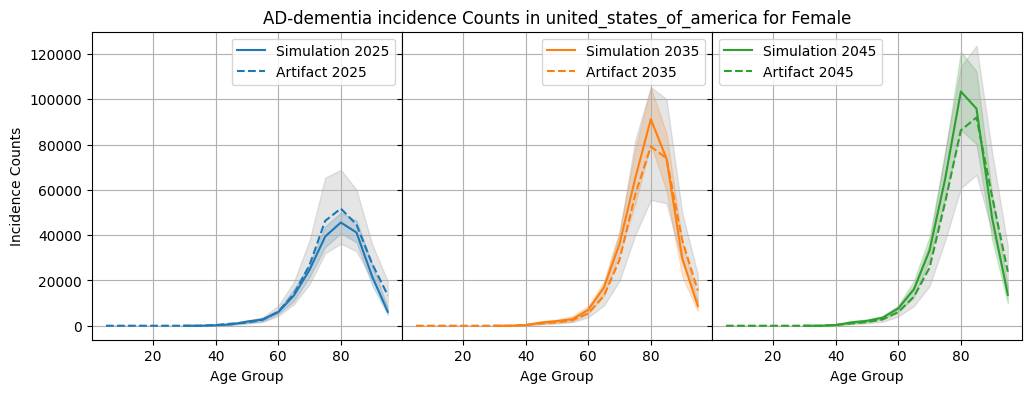

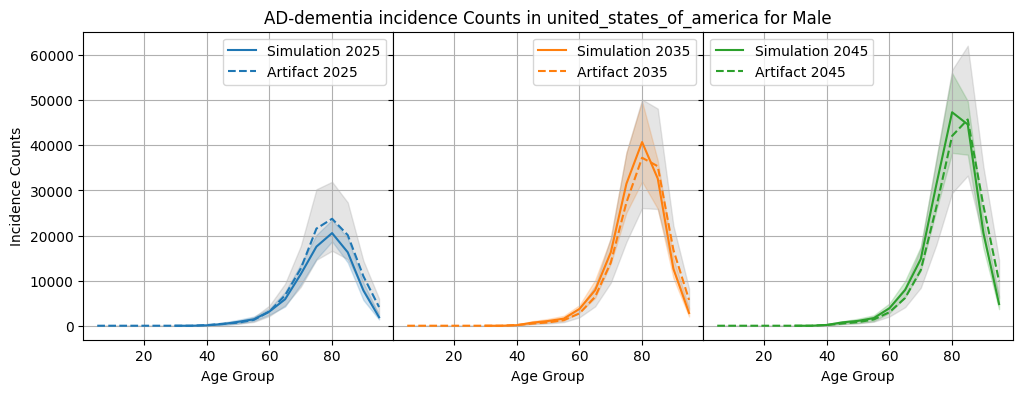

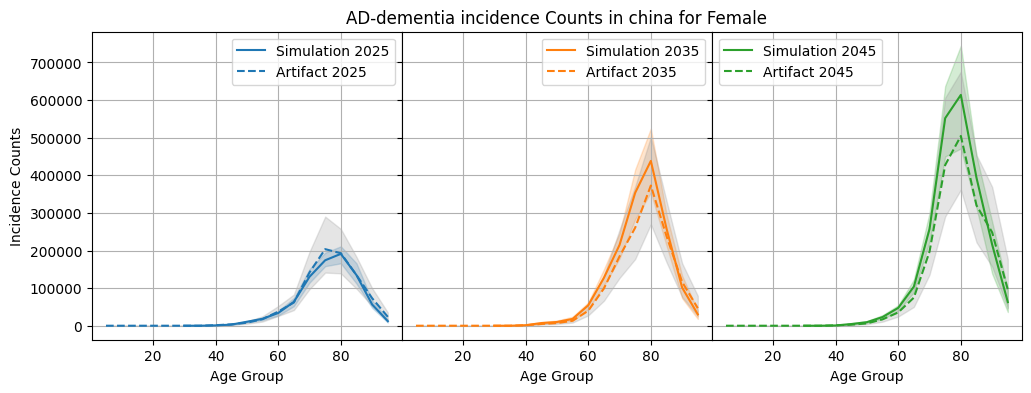

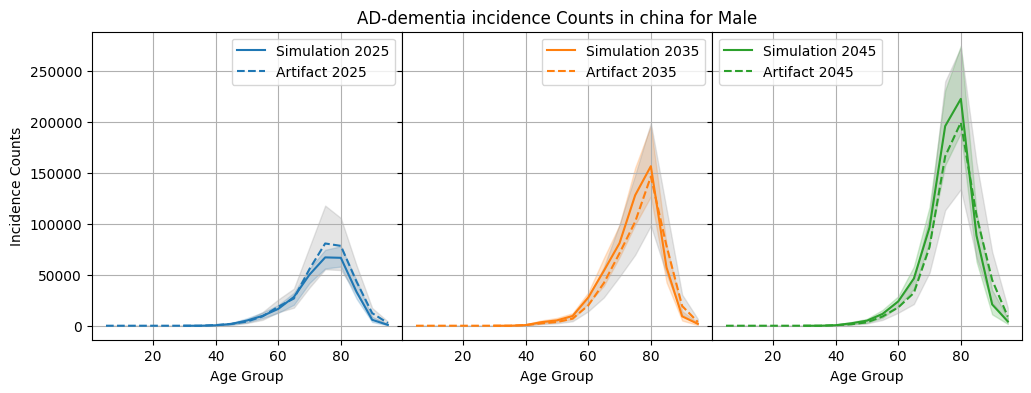

In [73]:
scenario = 'baseline'
for location in new_sims_with_scale.location.unique():
    for sex in new_sims_with_scale.sex.unique():
        fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
        plt.subplots_adjust(wspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query(
                'location == @location and event_year == @year and sex == @sex'
                ' and scenario == @scenario'
                )

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 1:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 0:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend()#(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

In [74]:
plot_data

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
186,2045,china,30_to_34,Male,baseline,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
418,2045,china,35_to_39,Male,baseline,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12,35 to 39,35.0,40.0
650,2045,china,40_to_44,Male,baseline,25.0,506.137819,295.185570,0.000000,0.000000,361.527014,1084.581041,1084.581041,13,40 to 44,40.0,45.0
882,2045,china,45_to_49,Male,baseline,25.0,2378.847749,644.779484,1084.581041,1301.497249,2349.925588,3579.117434,3796.033642,14,45 to 49,45.0,50.0
1114,2045,china,50_to_54,Male,baseline,25.0,4974.611706,1125.388939,1988.398574,2856.063407,5061.378190,6688.249751,6688.249751,15,50 to 54,50.0,55.0
1346,2045,china,55_to_59,Male,baseline,25.0,11576.094974,2198.761010,6869.013257,7845.136194,11388.100927,15545.661582,16087.952103,16,55 to 59,55.0,60.0
1578,2045,china,60_to_64,Male,baseline,25.0,23875.243974,3109.937941,15726.425089,18654.793899,23680.019387,28886.008382,30187.505631,17,60 to 64,60.0,65.0
1810,2045,china,65_to_69,Male,baseline,25.0,46347.763136,6621.967057,34706.593300,36333.464861,46275.457733,58097.391076,59290.430221,18,65 to 69,65.0,70.0
2042,2045,china,70_to_74,Male,baseline,25.0,96542.173696,10089.605158,78270.598432,81632.799658,95443.131575,116556.309166,123823.002138,19,70 to 74,70.0,75.0
2274,2045,china,75_to_79,Male,baseline,25.0,196019.946743,22087.631385,154733.561796,157661.930606,203539.708624,231268.830563,236800.193870,20,75 to 79,75.0,80.0


## Verifying Prevalence of AD Dementia

In [75]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            # This key is the prevalence of all 5 states:
            # 'cause.alzheimers_consistent.alzheimers_prevalence'
            # This key is the prevalence of the 3 dementia states:
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [76]:
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [77]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
# dementia_states = ['alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']
dementia_states = ['alzheimers_disease_state']
scenario = 'baseline'

# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_dementia = person_time.query("sub_entity in @dementia_states and scenario == @scenario")
person_time_dementia = person_time_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])
person_time_dementia['total_prev'] = person_time_dementia['value'] / person_time_dementia['ratio']
person_time_dementia = person_time_dementia.groupby(cols, observed=True).sum(numeric_only=True)
person_time_dementia = person_time_dementia.groupby(
    [c for c in cols if c != 'input_draw'], observed=True).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

person_time_dementia = person_time_dementia.merge(age_dictionary, on=['age_group'])
person_time_dementia = person_time_dementia.loc[person_time_dementia['age_group_id'].isin(age_group_ids)]
person_time_dementia.tail()

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
1619,2049,united_states_of_america,95_plus,Male,baseline,25.0,44377.693425,5433.552125,36208.104367,36265.921700,44639.798665,5.385685e+04,5.434829e+04,33,95 to 99,95.0,125.0
1620,2050,china,95_plus,Female,baseline,25.0,727061.122227,237911.013822,341644.759960,376935.141440,744899.067985,1.159016e+06,1.228408e+06,33,95 to 99,95.0,125.0
1621,2050,china,95_plus,Male,baseline,25.0,37160.285307,16868.435645,12970.431172,13240.648488,35218.323529,6.508634e+04,6.719404e+04,33,95 to 99,95.0,125.0
1622,2050,united_states_of_america,95_plus,Female,baseline,25.0,124568.406113,16464.177107,94964.968341,99677.080925,122380.020084,1.517609e+05,1.594072e+05,33,95 to 99,95.0,125.0
1623,2050,united_states_of_america,95_plus,Male,baseline,25.0,45731.582623,5933.888599,36184.013812,36357.465809,45699.783091,5.628035e+04,5.849187e+04,33,95 to 99,95.0,125.0


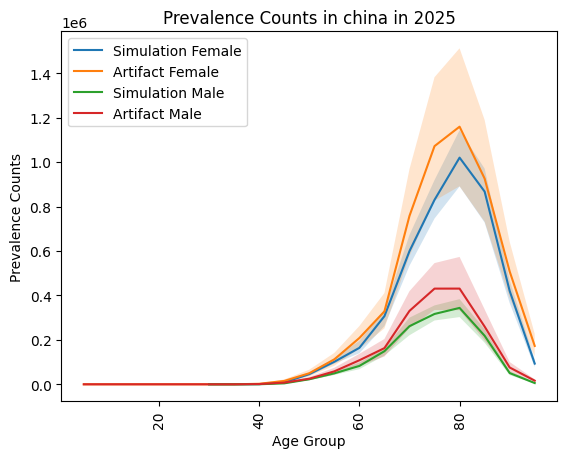

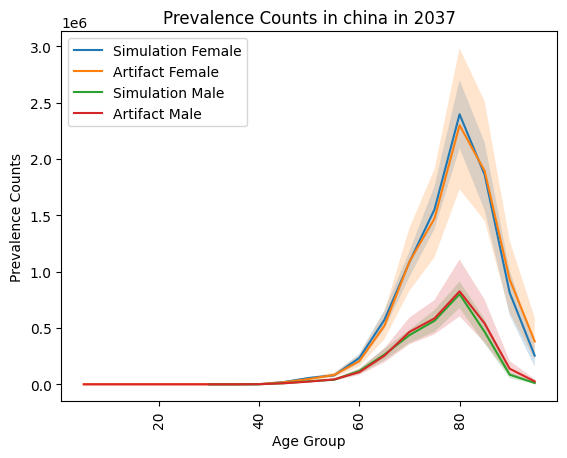

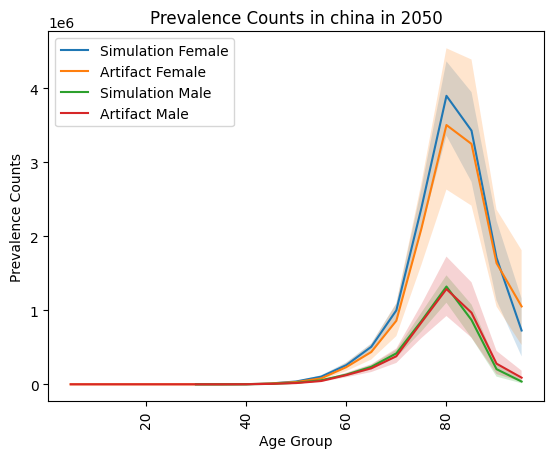

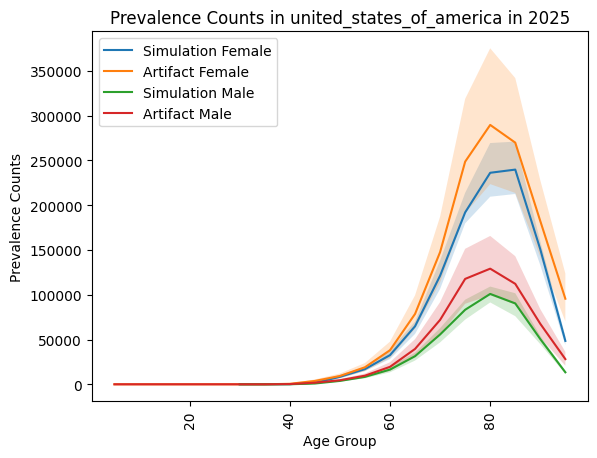

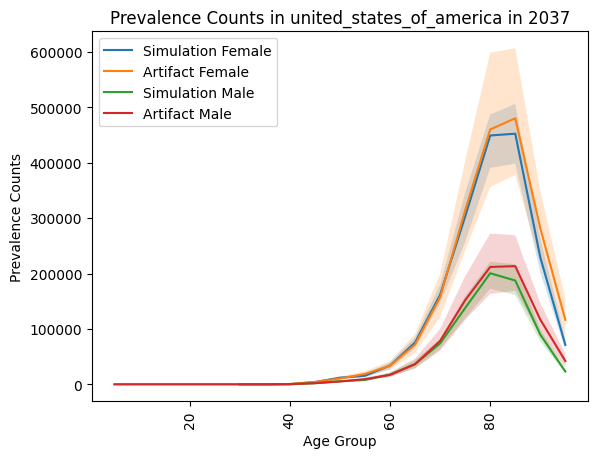

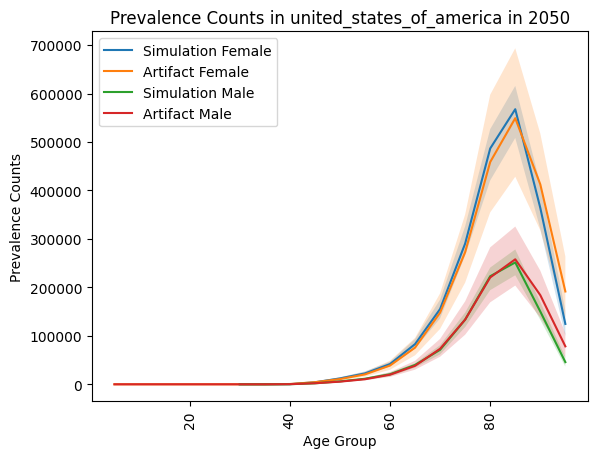

<Figure size 640x480 with 0 Axes>

In [78]:
for location in person_time_dementia.location.unique():
    for year in [2025,2037,2050]:
        for sex in person_time_dementia.sex.unique(): # [:1]:
            plot_data = person_time_dementia.loc[(person_time_dementia.location == location) & (person_time_dementia.event_year == year) & (person_time_dementia.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [79]:
cols = ['input_draw','event_year','location', 'scenario'] #, 'age_group']

# # FIXME: Don't reload person-time
# person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,event_year,location,scenario,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,china,baseline,25.0,101568.885749,134.072257,101252.292950,101304.314305,101577.177276,101774.698973,101794.431211
1,2022,china,bbbm_testing_and_treatment,25.0,101568.885749,134.072257,101252.292950,101304.314305,101577.177276,101774.698973,101794.431211
2,2022,united_states_of_america,baseline,25.0,101135.075483,74.201589,101012.616016,101033.245175,101141.672827,101278.104312,101281.691992
3,2022,united_states_of_america,bbbm_testing_and_treatment,25.0,101135.075483,74.201589,101012.616016,101033.245175,101141.672827,101278.104312,101281.691992
4,2023,china,baseline,25.0,109107.916222,577.097328,107889.002053,108049.251745,109244.845996,110098.315127,110303.709788


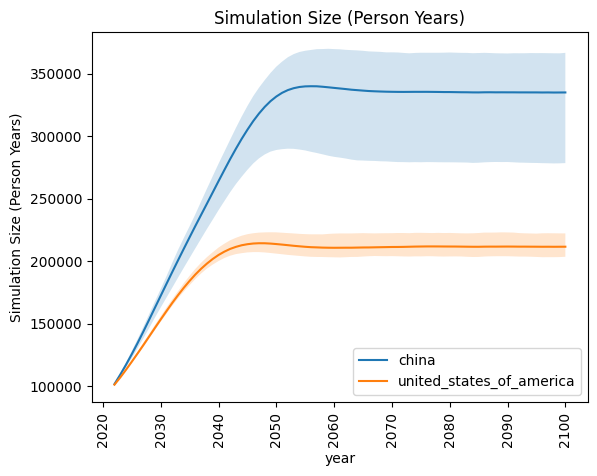

In [80]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[
        (person_time_total.location == location) & (person_time_total.scenario == scenario)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()

# Decompose person-time by state

In [81]:
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,236,0.000000,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,187,0.000000,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,204,0.000000,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,211,0.000000,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,248,0.000000,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,123,60.791239,china
4265996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,249,39.364819,china
4265997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,7,39.364819,china
4265998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,bbbm_testing_and_treatment,187,45.842574,china


In [82]:
cols = ["input_draw", "event_year", "sub_entity", "location", "scenario"]  # , 'age_group']

person_time_total = person_time.groupby(cols, observed=True)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,event_year,sub_entity,location,scenario,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,alzheimers_blood_based_biomarker_state,china,baseline,25.0,49506.292129,352.123225,48791.446954,48848.849829,49542.866530,50116.895277,50239.474333
1,2022,alzheimers_blood_based_biomarker_state,china,bbbm_testing_and_treatment,25.0,49506.292129,352.123225,48791.446954,48848.849829,49542.866530,50116.895277,50239.474333
2,2022,alzheimers_blood_based_biomarker_state,united_states_of_america,baseline,25.0,48715.228693,323.333486,48245.820671,48260.171389,48662.888433,49381.420945,49501.010267
3,2022,alzheimers_blood_based_biomarker_state,united_states_of_america,bbbm_testing_and_treatment,25.0,48715.228693,323.333486,48245.820671,48260.171389,48662.888433,49381.420945,49501.010267
4,2022,alzheimers_disease_state,china,baseline,25.0,30484.474305,438.652056,29615.299110,29773.455989,30499.761807,31365.090212,31479.895962
...,...,...,...,...,...,...,...,...,...,...,...,...
943,2100,alzheimers_disease_state,united_states_of_america,bbbm_testing_and_treatment,25.0,61090.830062,2378.714514,56171.603012,57577.973443,60471.337440,65057.587953,65135.321013
944,2100,alzheimers_mild_cognitive_impairment_state,china,baseline,25.0,73164.647775,6221.230379,59191.233402,60592.820260,74511.622177,80779.398220,82368.142368
945,2100,alzheimers_mild_cognitive_impairment_state,china,bbbm_testing_and_treatment,25.0,70153.767337,6173.791817,55713.177276,57302.220397,71692.802190,77907.062012,79377.412731
946,2100,alzheimers_mild_cognitive_impairment_state,united_states_of_america,baseline,25.0,46056.997235,1364.028558,43934.127310,44135.635318,45576.985626,48985.480630,49091.915127


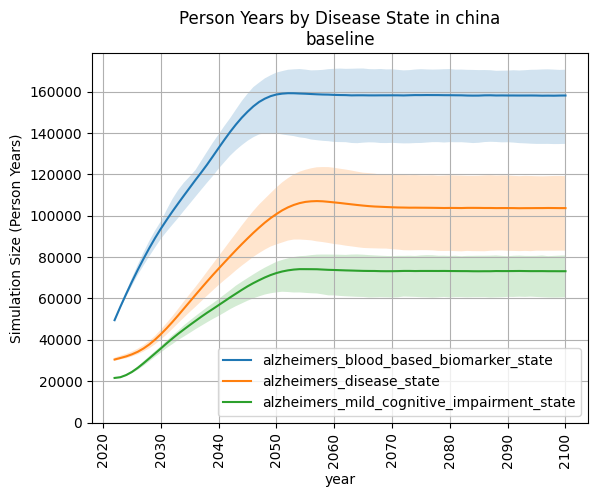

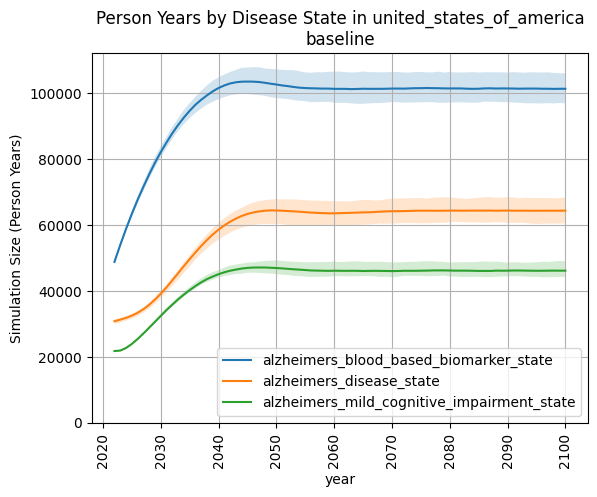

<Figure size 640x480 with 0 Axes>

In [83]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity and scenario == @scenario"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}\n{scenario}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()
    plt.figure()

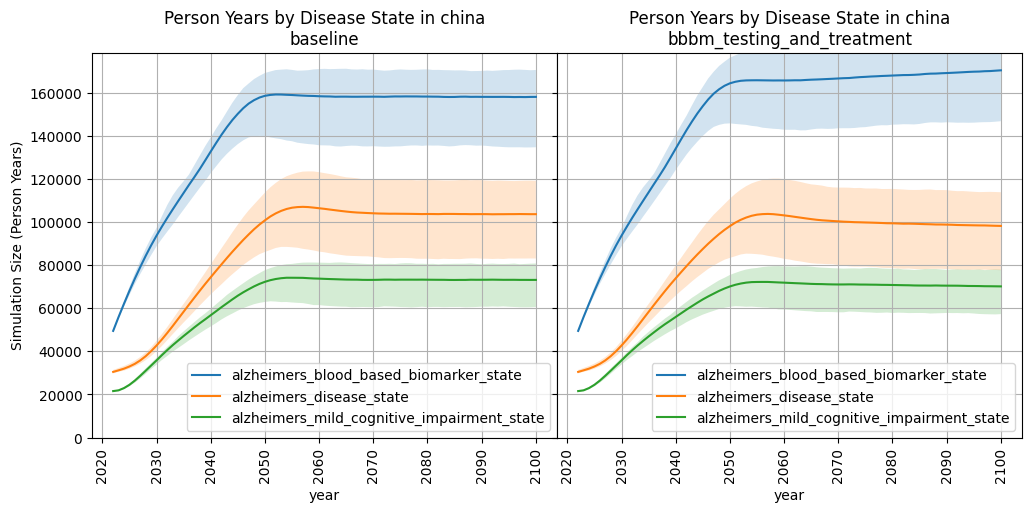

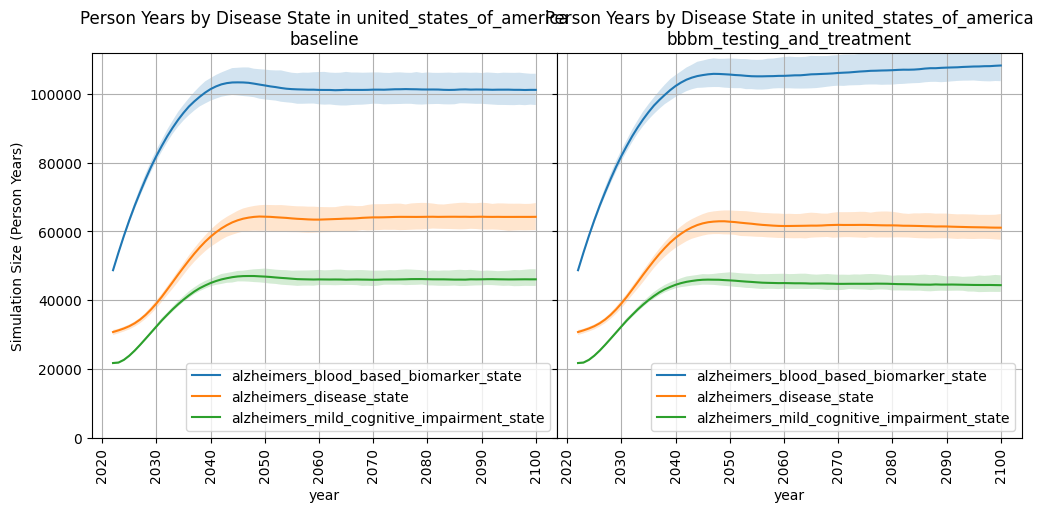

In [84]:
for location in person_time_total.location.unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0)
    for scenario, ax in zip (['baseline', 'bbbm_testing_and_treatment'], axs):
        for sub_entity in person_time_total.sub_entity.unique():
            plot_data = person_time_total.query(
                "location == @location and sub_entity == @sub_entity and scenario == @scenario"
            )
            ax.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
            ax.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )
        ax.set_title(f"Person Years by Disease State in {location}\n{scenario}")
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("year")
        if scenario == 'baseline':
            ax.set_ylabel("Simulation Size (Person Years)")
        ax.legend()
        ax.axis(ymin=0)
        ax.grid()

plt.show()

In [85]:
!date

Mon Jan 26 17:15:50 PST 2026
